# Premier traitement des données, création des cartes et quelques analyses

Importation des librairies nécessaires et des données

In [1]:
#on charge le dataset et on le met dans un dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from folium.plugins import HeatMap, MarkerCluster, FeatureGroupSubGroup
import folium
df = pd.read_csv('Data.csv', sep=',', low_memory=False)

Création du dataframe et traitement de préparation pour les analyses

In [3]:
# On ne peut pas garder toutes les colonnes, un choix s'opère donc. On garde les colonnes qui nous semblent les plus pertinentes pour notre étude.
# Data, dataframe général, possédant "eventid","latitude","longitude","iyear","imonth","iday","extended","resolution","country_txt","region_txt","provstate","city","success", "suicide","attacktype1_txt", "targtype1_txt","targsubtype1_txt","natlty1_txt","gname","nperps","claimed","weaptype1_txt","weapsubtype1_txt","nkill","nwound","dbsource"
Data = df[["eventid","iyear","imonth","latitude","longitude","iday","extended","resolution","country_txt","region_txt","provstate","city","success", "suicide","attacktype1_txt", "targtype1_txt","targsubtype1_txt","natlty1_txt","gname","nperps","claimed","weaptype1_txt","weapsubtype1_txt","nkill","nwound","dbsource"]]

#On remplace les valeurs vides de la colonne claimed par 0
Data['claimed'].fillna(0,inplace=True)
#On remplace les valeurs vides de la colonne nperps par 0
Data['nperps'].fillna(0,inplace=True)
#On remplace les valeurs vides de la colonne nkill par 0
Data['nkill'].fillna(0,inplace=True)
#On remplace les valeurs vides de la colonne nwound par 9
Data['nwound'].fillna(0,inplace=True)
#on remplace les valeurs vides de la colonne resolution par la date de l'attentat dans le format "jour/mois/année"
Data['resolution'].fillna(Data['iday'].astype(str) + "/" + Data['imonth'].astype(str) + "/" + Data['iyear'].astype(str),inplace=True)
#On drop les coordonnées null
Data = Data.dropna(subset=['latitude', 'longitude'])
Data.to_csv("Trait2.csv")


Première analyse des données fonctionnelle

In [5]:
# On regarde le nombre de d'attentats revendiqués par rapport au nombre total 

Revendiqué = df[["claimed"]]

#On récupère le nombre de ligne ou la colonne "claimed" est égale à 1 dans la variable "count"

count = Revendiqué[Revendiqué.claimed == 1].count()

#On récupère le nombre de ligne total dans la variable "count2"

count2 = Revendiqué.count()

#On calcule le pourcentage de ligne ou la colonne "claimed" est égale à 1

pourcentage = (count/count2)*100

print(pourcentage)


claimed    16.445302
dtype: float64


Visualisation graphique 

<Axes: title={'center': "Nombre d'attentats par année"}, xlabel='iyear'>

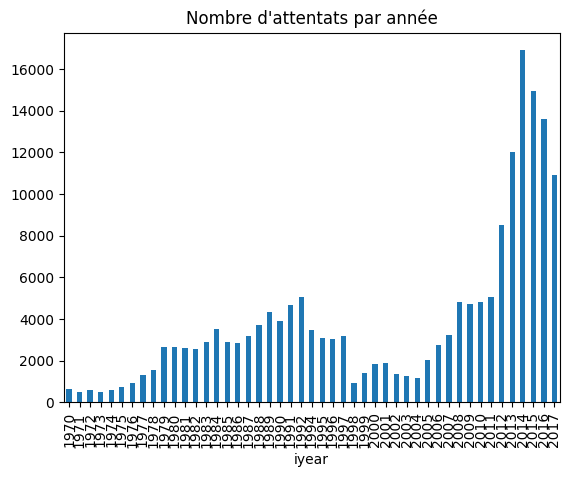

In [6]:
 # On regarde le nombre d'attentats par année pour voir comment évolue le terrorisme au fil des années

#On récupère le nombre d'attentats par année dans la variable "YearCount"

YearCount = df[["eventid","iyear"]].groupby('iyear').count()

#On affiche le bar chart du nombre d'attentats par année

YearCount.plot(kind='bar', legend=False, title="Nombre d'attentats par année")

Carte rassemblant tous les attentats en clusters (cartouche à exécution longue)

In [7]:


# créer la carte centrée sur la position moyenne des événements
map = folium.Map(location=[Data['latitude'].mean(), Data['longitude'].mean()], zoom_start=4)

# créer un groupe de marqueurs clusterisés
marker_cluster = MarkerCluster().add_to(map)

# ajouter un marqueur pour chaque événement dans le groupe de marqueurs clusterisés
for index, row in Data.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(marker_cluster)

# créer un groupe pour afficher le nombre de marqueurs dans chaque cluster
sub_group = folium.plugins.FeatureGroupSubGroup(marker_cluster, 'Events Count')

# ajouter le groupe à la carte
map.add_child(sub_group)

# ajouter un compteur pour chaque cluster
for i, layer in enumerate(marker_cluster._children.values()):
    count = len(layer._children)
    bounds = layer.get_bounds()
    pos = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2]
    folium.Marker(location=pos, icon=folium.Icon(icon='info-sign'), tooltip=str(count)).add_to(sub_group)

map.save("CarteGenerale.html")

KeyboardInterrupt: 

Heatmaps par continent

In [ ]:
def create_heatmap_for_region(region_data, region_name):
    # Créer une carte centrée sur les coordonnées moyennes de la région
    map_center = [region_data['latitude'].mean(), region_data['longitude'].mean()]
    region_map = folium.Map(location=map_center, zoom_start=4)

    # Préparez les données pour la heatmap
    heat_data = [[row['latitude'], row['longitude']] for index, row in region_data.iterrows()]

    # Ajoutez la heatmap à la carte
    HeatMap(heat_data).add_to(region_map)

    # Sauvegarder la heatmap dans un fichier HTML
    region_map.save(f'{region_name}_heatmap.html')

    print(f'{region_name} heatmap created')


In [ ]:
regions = Data['region_txt'].unique()
for region in regions:
    region_data = Data[Data['region_txt'] == region]
    create_heatmap_for_region(region_data, region)


Central America & Caribbean heatmap created
North America heatmap created
Southeast Asia heatmap created
Western Europe heatmap created
East Asia heatmap created
South America heatmap created
Eastern Europe heatmap created
Middle East & North Africa heatmap created
Australasia & Oceania heatmap created
South Asia heatmap created
Sub-Saharan Africa heatmap created
Central Asia heatmap created


Cartes des attentats par continent (exécution longue)

In [ ]:
# Crée une carte par continent, visant à afficher chaque attentat et son nombre de victimes en cliquant dessus
def create_map_for_region(region_data, region_name):
    # Crée une carte centrée sur les coordonnées moyennes de la région
    map_center = [region_data['latitude'].mean(), region_data['longitude'].mean()]
    region_map = folium.Map(location=map_center, zoom_start=4)

    # Ajoute un marqueur pour chaque événement
    for index, row in region_data.iterrows():
        folium.Marker(location=[row['latitude'], row['longitude']],
                      popup=f'Victims: {row["nkill"] + row["nwound"]}').add_to(region_map)

    # Sauvegarde la carte dans un fichier HTML
    region_map.save(f'{region_name}_map.html')

    print(f'{region_name} map created')


In [ ]:
regions = Data['region_txt'].unique()
for region in regions:
    region_data = Data[Data['region_txt'] == region]
    create_map_for_region(region_data, region)


Central America & Caribbean map created
North America map created
Southeast Asia map created
Western Europe map created
East Asia map created
South America map created
Eastern Europe map created
Middle East & North Africa map created
Australasia & Oceania map created
South Asia map created
Sub-Saharan Africa map created
Central Asia map created
